In [21]:
import re
import random
import pandas as pd
import hashlib

In [22]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.75) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [23]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
FSLogix,258.842849,10.785119,24
Azure Kubernetes Learning Path,308.758313,61.751663,5
Vocab,585.590737,53.235522,11
Azure Functions + Visual Studio,615.580326,43.970023,14
Audit Report Tracker (Sharepoint List),709.096388,44.318524,16
OData,784.262781,52.284185,15
Azure AI Search,863.579959,61.684283,14
Search Engine Optimization,878.779104,109.847388,8
Debugging in VS Code,989.793454,43.034498,23
PnP Powershell,1250.531799,32.908732,38


# Histogram

41793.69


<Axes: >

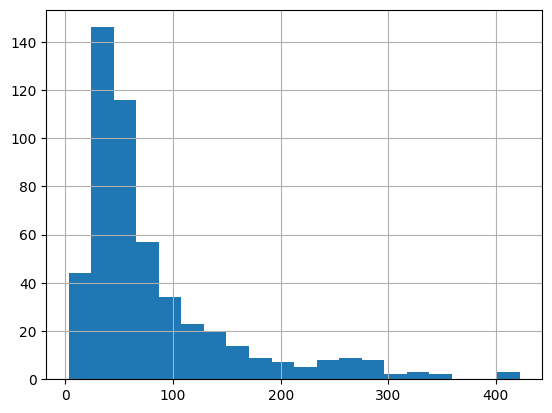

In [24]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [25]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [26]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [27]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [28]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [29]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [30]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [31]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [32]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

## Age Sum

In [33]:
# n=5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Max

In [34]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [35]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



## Card Count

In [36]:
n=3
existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'frequency', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)



Cards found: 510


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold
110,Azure Kubernetes Learning Path,Azure Container Instance is a service that loa...,dda972de0f461195a5556213d611eb72,-116.675537,-61.751663,116.675537,308.758313,0.657102,5,0,0
284,Azure Kubernetes Learning Path,Command in DockerFile\nRUN\tExecutes a command...,ef9b45c7ae5fd42ba63041b3d0a26cfe,-68.691003,-61.751663,116.675537,308.758313,0.657102,5,1,0
451,Azure Kubernetes Learning Path,The host network enables you to run the contai...,7d1d19fb0ff5f5fe583953307c29765b,-61.588955,-61.751663,116.675537,308.758313,0.657102,5,2,0
39,Search Engine Optimization,Duplicate content refers to identical or very ...,434bfc680dfb3b0c731255b52f64829b,-272.097581,-109.847388,272.097581,878.779104,0.047403,8,0,0
218,Search Engine Optimization,Link Explorer by Moz is a tool for analyzing a...,36534edfd2dd13bd32a29f0f41631993,-216.295141,-109.847388,272.097581,878.779104,0.047403,8,1,0
389,Search Engine Optimization,Link equity refers to the value or authority p...,ce2ca16db51c1a8517bb9479cb67c9ff,-147.888380,-109.847388,272.097581,878.779104,0.047403,8,2,0
117,Vocab,Hieratic\nadjective\nSPA: hi-uh-RAT-ik\nIPA: /...,ca40d5a4cd7caf50cb01f3c6d0964e6d,-86.949794,-53.235522,86.949794,585.590737,0.603082,11,0,0
291,Vocab,Lacunary\nadjective\nSPA: LACK-yoo-nary\nIPA: ...,dd5b0bcb1d9dc85857c09e77945b64c7,-82.033356,-53.235522,86.949794,585.590737,0.603082,11,1,0
456,Vocab,Palimpsest\nnoun\nSPA: PAL-imps-est\nIPA: /ˈpæ...,83dd5618c76e96fde6405f55d07dbe7d,-76.670716,-53.235522,86.949794,585.590737,0.603082,11,2,0
176,Powershell,-AllowClobber\nAllows overwriting of existing ...,7714f3ad42cf33e4637786d64df9b836,-300.755643,-129.368769,300.755643,1552.425225,0.938165,12,0,0


In [37]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold
110,Azure Kubernetes Learning Path,Azure Container Instance is a service that loa...,dda972de0f461195a5556213d611eb72,-116.675537,-61.751663,116.675537,308.758313,0.657102,5,0,0
284,Azure Kubernetes Learning Path,Command in DockerFile\nRUN\tExecutes a command...,ef9b45c7ae5fd42ba63041b3d0a26cfe,-68.691003,-61.751663,116.675537,308.758313,0.657102,5,1,0
451,Azure Kubernetes Learning Path,The host network enables you to run the contai...,7d1d19fb0ff5f5fe583953307c29765b,-61.588955,-61.751663,116.675537,308.758313,0.657102,5,2,0
39,Search Engine Optimization,Duplicate content refers to identical or very ...,434bfc680dfb3b0c731255b52f64829b,-272.097581,-109.847388,272.097581,878.779104,0.047403,8,0,0
218,Search Engine Optimization,Link Explorer by Moz is a tool for analyzing a...,36534edfd2dd13bd32a29f0f41631993,-216.295141,-109.847388,272.097581,878.779104,0.047403,8,1,0
389,Search Engine Optimization,Link equity refers to the value or authority p...,ce2ca16db51c1a8517bb9479cb67c9ff,-147.888380,-109.847388,272.097581,878.779104,0.047403,8,2,0
117,Vocab,Hieratic\nadjective\nSPA: hi-uh-RAT-ik\nIPA: /...,ca40d5a4cd7caf50cb01f3c6d0964e6d,-86.949794,-53.235522,86.949794,585.590737,0.603082,11,0,0
291,Vocab,Lacunary\nadjective\nSPA: LACK-yoo-nary\nIPA: ...,dd5b0bcb1d9dc85857c09e77945b64c7,-82.033356,-53.235522,86.949794,585.590737,0.603082,11,1,0
456,Vocab,Palimpsest\nnoun\nSPA: PAL-imps-est\nIPA: /ˈpæ...,83dd5618c76e96fde6405f55d07dbe7d,-76.670716,-53.235522,86.949794,585.590737,0.603082,11,2,0
176,Powershell,-AllowClobber\nAllows overwriting of existing ...,7714f3ad42cf33e4637786d64df9b836,-300.755643,-129.368769,300.755643,1552.425225,0.938165,12,0,0


In [38]:
existing_cards['age'].mean()

np.float64(-81.94840497300501)